<div align="center">



# Deep Learning
## Electrical Engineering Department
### Homework 5: Variational Autoencoders and Vector Quantized Varitional Autoencoders
#### Ali Majlesi
ali.majlesi@sharif.edu
</div>


### Full Name : Ehsan Merrikhki
### Student Number : 400101967


This youtعbe video expalins VQ-VAEs : [videos link](https://www.youtube.com/watch?v=VZFVUrYcig0&ab_channel=AleksaGordi%C4%87-TheAIEpiphany)
## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [65]:
!pip3 install umap-learn

In [66]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [68]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

Files already downloaded and verified
Files already downloaded and verified


In [69]:
data_variance = np.var(training_data.data / 255.0)
print(f"standard deviation :{np.sqrt(data_variance):.3f}")

standard deviation :0.252


## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [70]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        # Embedding layer for codebook vectors
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        # Initialize embeddings with uniform distribution
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # Convert inputs from BCHW (batch, channel, height, width) -> BHWC (batch, height, width, channel)
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # TODO: Fill in the code to calculate the distances between the input vectors and embedding vectors.
        # You will need to compute the squared distance between each flattened input vector and each codebook embedding.
        # Hint: ||A - B||^2 = ||A||^2 + ||B||^2 - 2* A.B
        #       If A and B are stacks of vectors, A.B can be computed using "A @ Transpose(B)"
        #       Which @ represents matrix multiplaction. ||A||^2 and ||B||^2 must be repeated along the second axis.
        # Compute ||A||^2
        input_sq = torch.sum(flat_input ** 2, dim=1, keepdim=True)  # (B*H*W, 1)
        # Compute ||B||^2
        embedding_sq = torch.sum(self._embedding.weight ** 2, dim=1)  # (num_embeddings,)
        # Compute A.B
        input_dot_embedding = torch.matmul(flat_input, self._embedding.weight.t())  # (B*H*W, num_embeddings)
        # Compute distances
        distances = input_sq + embedding_sq - 2 * input_dot_embedding  # (B*H*W, num_embeddings)


        # TODO: Use the distances to find the index of the closest embedding for each input vector.
        # Hint: Use torch.argmin to find the closest codebook vector. The shape of encoding_indices should be (B*H*W, 1).
        encoding_indices = torch.argmin(distances, dim=1)  # (B*H*W,)

        # TODO: Create a one-hot encoding matrix where each input is assigned its closest embedding.
        # Hint: Use torch.zeros to create an empty matrix and use encodings.scatter_ to fill the one-hot encoding. The shape of encodings should be (B*H*W, _num_embeddings).
        encodings = F.one_hot(encoding_indices, self._num_embeddings).type(flat_input.dtype)  # (B*H*W, num_embeddings)

        # Quantize the input by replacing each input with its closest embedding.
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        quantized = quantized.view(input_shape)  # (B, H, W, C)

        # TODO: Compute the loss for the quantization.
        # - e_latent_loss: Difference (MSE distance) between the input and the quantized result (detach the quantized).
        # - q_latent_loss: Difference (MSE distance) between the quantized result and the input (detach the input).
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)  # (B, H, W, C)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())  # (B, H, W, C)
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        # Straight-through estimator: Preserve gradient flow for the input, but pass quantized values in the forward pass.
        quantized = inputs + (quantized - inputs).detach()

        # TODO: Compute perplexity for the codebook usage.
        # Hint: Average over the encodings and use the formula for perplexity.
        #       See https://en.wikipedia.org/wiki/Perplexity for more details about perplexity.
        #       Perplexity measures model's confidence in the generated output for classification tasks.
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Convert quantized from BHWC -> BCHW (back to original shape)
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

# Lets test the VectorQuantizer function:
# Define parameters
batch_size = 4
channels = 3
height = 16
width = 16
num_embeddings = 512
embedding_dim = channels
commitment_cost = 0.25

# Create random input tensor
inputs = torch.randn(batch_size, channels, height, width)

# Initialize the VectorQuantizer
vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

# Forward pass
loss, quantized, perplexity, encodings = vq(inputs)

# Check output shape
assert quantized.shape == inputs.shape, f"Expected shape {inputs.shape}, but got {quantized.shape}"
print("Output shape is correct.")

Output shape is correct.


We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [71]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [72]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()

        # TODO: Complete the Sequential block
        # - The first layer is a ReLU activation function.
        # - The second layer is a Conv2D layer with a 3x3 kernel, stride 1, padding 1, no bias.
        # - Another ReLU activation function follows.
        # - Finally, a Conv2D layer with a 1x1 kernel and no bias.
        self._block = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=in_channels, out_channels=num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        # TODO: Add the residual connection.
        # Hint: Add the input tensor `x` to the output of `self._block(x)`
        return x + self._block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()

        # TODO: Create a list of residual layers using nn.ModuleList and the Residual block.
        # Use a for loop to create `num_residual_layers` of Residual blocks.
        # Hint: Each Residual block takes the same `in_channels`, `num_hiddens`, and `num_residual_hiddens`.
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([
            Residual(in_channels, num_hiddens, num_residual_hiddens) 
            for _ in range(self._num_residual_layers)
        ])

    def forward(self, x):
        # TODO: Implement the forward pass.
        # Apply each Residual layer to the input `x` in sequence.
        # Hint: Use a for loop to apply each residual layer to `x`.
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)

        # Apply a ReLU activation function after all the residual layers have been applied.
        return F.relu(x)


In [73]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        # TODO: Add the first Conv2D layer.
        # This layer reduces the spatial dimensions by half (stride=2) and outputs `num_hiddens//2` channels.
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        # TODO: Add the second Conv2D layer.
        # This layer again reduces the spatial dimensions by half and outputs `num_hiddens` channels. The kernel size and padding is similar to the first layer.
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2, 
                                out_channels=num_hiddens,
                                kernel_size=4,
                                stride=2, padding=1)

        # TODO: Add the third Conv2D layer.
        # This layer keeps the spatial dimensions the same (stride=1, padding=1) and outputs `num_hiddens` channels. The kernel size of this layer is 3.
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens, 
                                out_channels=num_hiddens,
                                kernel_size=3,
                                stride=1, padding=1)

        # Residual Stack to add more representational power.
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        # TODO: Pass the input through the first Conv2D layer followed by a ReLU activation.
        x = self._conv_1(inputs)
        x = F.relu(x)

        # TODO: Pass the result through the second Conv2D layer followed by a ReLU activation.
        x = self._conv_2(x)
        x = F.relu(x)

        # TODO: Pass the result through the third Conv2D layer.
        x = self._conv_3(x)

        # Pass the result through the Residual Stack.
        return self._residual_stack(x)


In [74]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        # TODO: Add the first Conv2D layer.
        # This layer keeps the spatial dimensions the same (stride=1, padding=1) and outputs `num_hiddens` channels.
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        # Residual Stack to refine the representation.
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        # TODO: Add the first transposed Conv2D (deconvolution) layer.
        # This layer upsamples the input, doubling the spatial dimensions and halving the number of channels. Use kernel_szie = 4 for this layer.
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                               out_channels=num_hiddens//2,
                                               kernel_size=4,
                                               stride=2,
                                               padding=1)

        # TODO: Add the second transposed Conv2D (deconvolution) layer.
        # This layer upsamples the input, doubling the spatial dimensions and outputs 3 channels (for RGB images). Use kernel_szie = 4 for this layer.
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                               out_channels=3,
                                               kernel_size=4,
                                               stride=2,
                                               padding=1)

    def forward(self, inputs):
        # TODO: Pass the input through the first Conv2D layer.
        x = F.relu(self._conv_1(inputs))
        

        # Pass the result through the Residual Stack.
        x = self._residual_stack(x)

        # TODO: Pass the result through the first transposed Conv2D layer followed by a ReLU activation.
        x = F.relu(self._conv_trans_1(x))

        # TODO: Pass the result through the second transposed Conv2D layer to output the final reconstructed image.
        return self._conv_trans_2(x)


## Train

We use the hyperparameters from the author's code:

In [75]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [76]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [77]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [78]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [79]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [80]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [81]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance

    # TODO: Calculate Total loss which is th sum of recon_error and vq_loss
    loss = vq_loss + recon_error
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.602
perplexity: 1.892

200 iterations
recon_error: 0.412
perplexity: 1.987

300 iterations
recon_error: 0.374
perplexity: 1.987

400 iterations
recon_error: 0.353
perplexity: 1.969

500 iterations
recon_error: 0.341
perplexity: 1.918

600 iterations
recon_error: 0.306
perplexity: 2.591

700 iterations
recon_error: 0.239
perplexity: 4.762

800 iterations
recon_error: 0.174
perplexity: 11.172

900 iterations
recon_error: 0.142
perplexity: 20.273

1000 iterations
recon_error: 0.128
perplexity: 28.151

1100 iterations
recon_error: 0.119
perplexity: 35.918

1200 iterations
recon_error: 0.113
perplexity: 39.130

1300 iterations
recon_error: 0.109
perplexity: 42.368

1400 iterations
recon_error: 0.106
perplexity: 45.537

1500 iterations
recon_error: 0.102
perplexity: 50.302

1600 iterations
recon_error: 0.100
perplexity: 54.446

1700 iterations
recon_error: 0.097
perplexity: 61.362

1800 iterations
recon_error: 0.093
perplexity: 69.313

1900 iterations
recon_erro

## Plot Loss

In [90]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

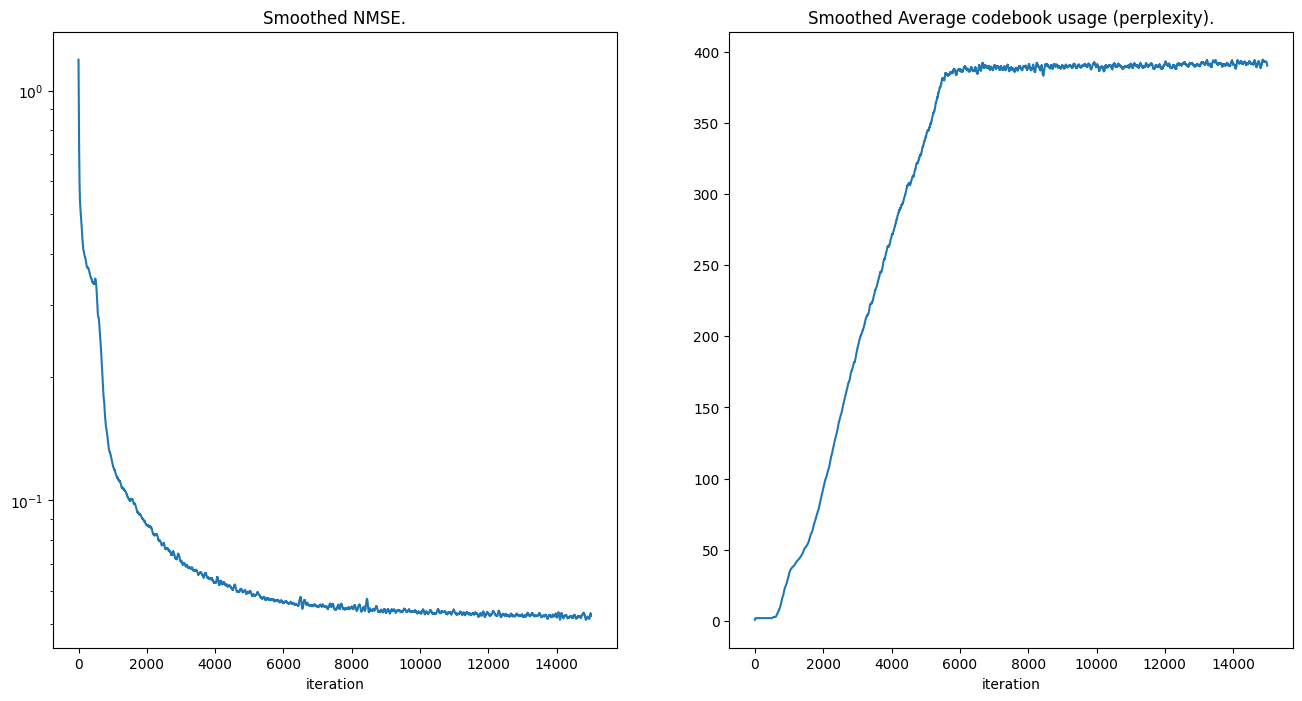

In [91]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [92]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [93]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

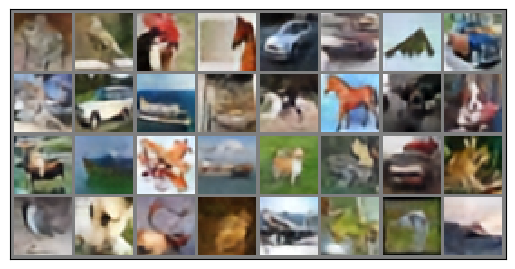

In [94]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

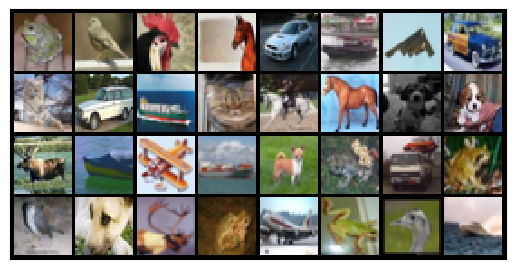

In [95]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [96]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

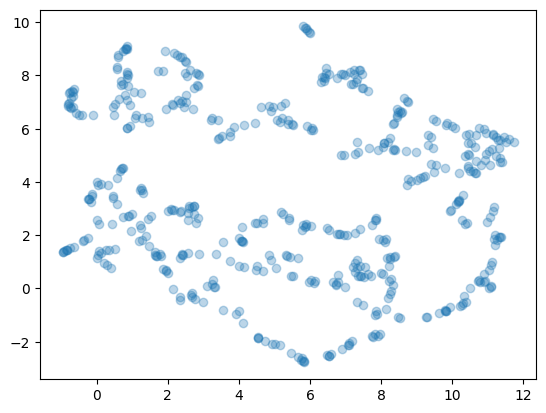

In [97]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)